# Importing

In [10]:
import numpy as np
import pandas as pd
import itertools as it
import statsmodels.api as sm
import statsmodels.formula.api as smf
from  matplotlib.colors import LinearSegmentedColormap
import scipy.cluster.hierarchy as sch

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import scipy.stats as stats

import GRIN_analysis_tools as ga
from path import Path
import warnings
from warnings import warn
from collections import OrderedDict
from sklearn.preprocessing import minmax_scale, scale
from scipy.integrate import simps
from numpy import trapz
from sklearn.metrics import auc
import warnings
warnings.filterwarnings('ignore')

In [11]:
path = 'dataset/'
# export_path = '/Volumes/lab-kohlj/home/shared/projects/pregnancy_2021/Figure_4/linked_figure_4/' 
export_path = 'output_figures/' 

# Tuning analysis

## Amount of behavioural data effect on tuning analysis

In [7]:
path = 'dataset/'

ID = 'JKAA40.4h'
state = 'PD18'
behav = 'retrieval to nest'
convolve = 'non_convolved'
fr = 10 # Inscopix framerate
window = 5 # Temporal window around each behavioural episode to analyse (in seconds)

# Load calcium and behavioural data
df = ga.load_inscopix(path + f'{ID}/{convolve}/{ID}_registered_{state}'+'.csv', normalisation='fixed interval')

_, bdf, _ = ga.preprocess_behaviour(path + f'{ID}/{ID}_behav_{state}_post.csv', df.shape[1])

# Keep only valid behaviours
behavs = bdf.columns[bdf.columns != 'invalid']
bdf = bdf[behavs]

# Extract and normalise behavioural episodes
episodes = ga.extract_behav_episodes(df, bdf, behav, window)
episodes = ga.behaviour_episode_zscore(episodes, [0, window * fr])
num_episodes = episodes.shape[0]

# Estimate tuning based on random subsets of behavioural episodes of varying sizes
subset_tuning = np.zeros((episodes.shape[:2])) * np.nan
for i in range(1, num_episodes):
    
    subset = np.random.choice(np.arange(num_episodes), i, replace = False)
    subset = episodes[subset]
    
    aucs = ga.episode_based_tuning(subset)
    
    subset_tuning[i] = aucs
    
    

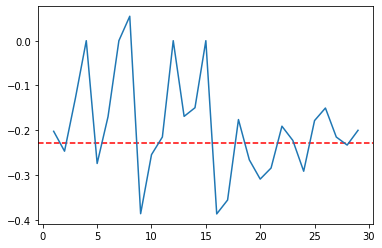

In [8]:
cell_n = 3

cell = subset_tuning[:,cell_n]

plt.axhline(np.mean(subset_tuning[-10:,cell_n]), c='r', linestyle='--')
plt.plot(cell)

In [9]:
print(df.shape[1])

41707


## Tuning calculation

In [10]:
# Path to calcium and behaviour recordings
path = 'dataset/'

# Experimental conditions
states = ['virgin', 'PD18']

# Analysis parameters

IDs = ['JKAA40.3e', 'JKAA40.4i','JKAA40.4h', 'JKAA40.5d', 'JKAA44.2i']

window = 4
average_estimates = False
num_episodes = 5
untuned_boundary = 0.25
tuned_boundary = 0.7
convolve = 'non_convolved'
# The number of behavioural episodes used to estimate tuning per behaviour type
num_episodes = {'pup sniff':1,
                'pup groom':1,
                'retrieval to nest': 1,
                'female nest contact':1,
                'male intruder contact':1,
                'female intruder contact': 1,
                'male anogenital sniff':1,
                'female anogenital sniff':1,
                'food pellet contact': 1,
                'screw contact':1}

# Defining output variables
tuning_results = pd.DataFrame(columns = ['State', 'Behaviour', 'Mouse', 'Cell', 'Tuning'])

# Calculating tuning for all recordings
for state in states:


    for ID in IDs:
        print(ID)

        df = ga.load_inscopix(path + f'{ID}/{convolve}/{ID}_registered_{state}'+'.csv', normalisation='fixed interval')
        try:
            aucs = ga.analyse_recording_episodewise(path, 
                                                    state,
                                                    ID, 
                                                    convolve,
                                                    window = window, 
                                                    num_episodes = num_episodes,
                                                    skip_overlap = False,
                                                    plotting = False)
 
            proportions = ga.tuning_proportions(aucs, untuned_boundary = untuned_boundary, tuned_boundary = tuned_boundary)

            num_cells = aucs.shape[0]

            # Packing recording results into a global output variable
            for behav in aucs.columns:
                recording = {}

                recording['State'] = [state] * num_cells
                recording['Behaviour'] = [behav] * num_cells
                recording['IDs'] = [ID] * num_cells
                recording['Mouse'] = [f'{ID}'] * num_cells
                recording['Cell'] = np.arange(num_cells)
                recording['Tuning'] = aucs[behav]
                recording['Mean tuning'] = [aucs[behav].mean()] * num_cells
                recording['Positive'] = [proportions[behav][0]] * num_cells
                recording['Untuned'] = [proportions[behav][1]] * num_cells
                recording['Negative'] = [proportions[behav][2]] * num_cells

                recording = pd.DataFrame(recording)
                tuning_results = pd.concat([tuning_results, recording])

        except ValueError:
            warnings.warn(f'Recording {ID}_{state} does not have any {behav} episode')

proportion_results = tuning_results.drop(columns=['Tuning', 'Cell']).drop_duplicates()                

JKAA40.3e
JKAA40.4i
JKAA40.4h
JKAA40.5d
JKAA44.2i
JKAA40.3e
JKAA40.4i
JKAA40.4h
JKAA40.5d
JKAA44.2i


In [11]:
tuning_results.to_csv('generated_dataset/tuning_results.csv')

## Tuning distributions

In [12]:
num_episodes = {'pup sniff':1,
                'pup groom':1,
                'retrieval to nest': 1,
                'female nest contact':1,
                'male intruder contact':1,
                'female intruder contact': 1,
                'male anogenital sniff':1,
                'female anogenital sniff':1,
                'food pellet contact': 1,
                'screw contact':1}

In [13]:
conditions = list(num_episodes.keys())
pdf_vs = []
pdf_Ps = []


skipped = 0
for n, condition in enumerate(conditions):
    behav_name = condition
    
    behav = np.array(tuning_results['Behaviour'] == behav_name).astype(int)

    subset =  behav
    subset = subset == 1
    subset = tuning_results[subset]
    subset = subset[['State', 'Mouse', 'Behaviour', 'Cell', 'Tuning', 'Positive']]
    
    # compute statistics per behaviour
    md = smf.mixedlm("Tuning ~ State", subset, groups=subset["Mouse"])
    mdf = md.fit(method=["lbfgs"])
    print(mdf.summary())
        
    try:
        subset = subset.reset_index()
        mean_v = subset[subset.State == 'virgin'].Positive.unique().mean()
        mean_P = subset[subset.State == 'PD18'].Positive.unique().mean()

        sns.set(font_scale=2) 
        sns.set_style("ticks")
        
        plt.subplots(figsize=[4,4])

        plt.hist(subset[subset.State == 'virgin'].Tuning, bins = 20, 
                 color = '#0E86D4',density = True, alpha = 0.3, histtype="stepfilled")
        plt.hist(subset[subset.State == 'PD18'].Tuning, bins = 20, 
                 color = '#d7301f',density = True, alpha = 0.3, histtype="stepfilled")
        
        plt.axvline(mean_v, color = '#0E86D4',linewidth = 2,
                    linestyle = 'dashed', alpha = 0.5)
        plt.axvline(mean_P, color = '#d7301f', linewidth = 2,
                    linestyle = 'dashed', alpha = 0.5)
    
        #plt.xlim([-1,1])
        plt.ylabel('Norm. density')
        plt.xlabel('Tuning index')
        
        plt.title(f'{behav_name}', pad=25)
        ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
       # plt.savefig(export_path + behav_name + '_density plot.pdf', dpi = 300, bbox_inches='tight')
        plt.savefig(export_path + behav_name + '_density plot.png', dpi = 300, bbox_inches='tight')
 
        if True:#n - skipped > 0:
            plt.legend([],[], frameon=False)
            plt.show()
            
            
    except ValueError:
        skipped += 1
        continue

LinAlgError: Singular matrix

## Tuning proportions

In [ ]:
behaviour = 'pup sniff' # retrieval to nest / pup sniff / pup groom
direction = 'untuned' # --> this is purely for naming exported images (also change sign in y axis accordingly)

behav = np.array(proportion_results['Behaviour'] == behaviour).astype(int)


subset = behav
subset = subset == 1
subset = proportion_results[subset]
subset['Tuned'] = subset['Positive'] + subset['Negative']
pairplot_data = np.zeros((len(IDs), 2, 4)) * np.nan

#compute paired percentage positive tuning statistics
_, p = stats.ttest_rel(subset[subset.State == 'virgin'].Untuned, 
                      subset[subset.State == 'PD18'].Untuned)

print(p)

for n, ID in enumerate(IDs):
    ID = subset[subset['IDs'] == ID]
    if ID.shape[0] < 2:
        continue
    pairplot_data[n] = np.array(ID[['Positive', 'Untuned', 'Negative', 'Tuned']])
subset.to_csv('generated_dataset/tuning_proportion.csv')

In [ ]:
sns.set(font_scale=2) 
sns.set_style("ticks")
plt.figure(figsize=[1,1.75])

colors = {0: '#0E86D4',
          1: '#d7301f'}
line_colors = {0: 'black', 1: 'black', 2:'black'}

# for tuning_type in range(3):
    
ax = ga.paired_data_lineplot(pairplot_data[:,:,1], #0 for positive, 1 for untuned, 2 for negative, 3 for tuned see above
                            label = ['Untuned'][0],
                            conditions = ['virgin', 'PD18'],
                            marker_colors = colors,
                            line_color = line_colors[0],
                            ylabel = 'Fraction of\nuntuned cells', line_width = 2)

ax.set_xticklabels( ('Vir', 'D18'), rotation=45)
ax.yaxis.set_major_locator(plt.MaxNLocator(2))
sns.despine(bottom=True)
plt.margins(x=0.2)
plt.ylim(0, 1)
plt.savefig(export_path + behaviour + '_'+ direction + '_tuning_index.pdf', dpi=300, transparent=True, bbox_inches = "tight")
plt.savefig('output_figures/'+ behaviour + '_'+ direction + '_tuning_index.png', dpi=300, transparent=True, bbox_inches = "tight")

# Selectivity analysis

## Selectivity Index based on tuning

In [2]:
print(tuning_results[tuning_results.Behaviour =='female nest contact'].Mouse.unique())
IDs = ['JKAA40.3e', 'JKAA40.4i','JKAA40.4h', 'JKAA40.5d', 'JKAA44.2i']
behaviour_pair = ['pup sniff', 'female intruder contact']
states = ['virgin', 'PD18']
tuning_results['Selectivity'] = np.NaN

for state in states:
    
    tuning = tuning_results[(tuning_results.Behaviour == behaviour_pair[0]) &
                            (tuning_results.State == state)]
    substract = tuning_results[(tuning_results.Behaviour == behaviour_pair[1])&
                             (tuning_results.State == state)]

    for mouse in IDs:
        
        tuned = tuning[tuning.Mouse == mouse]
        substracted = substract[substract.Mouse == mouse]
        selectivity = tuned['Tuning'].abs() - substracted['Tuning'].abs()
        
        tuning_results.loc[(tuning_results.State == state) &
                           (tuning_results.Mouse == mouse)&
                           (tuning_results.Behaviour == behaviour_pair[0]), 
                           'Selectivity'] = selectivity
       

NameError: name 'tuning_results' is not defined

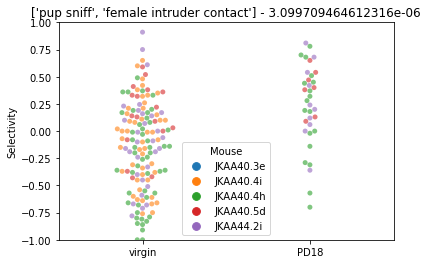

In [15]:
tuning_plot = tuning_results.dropna(subset = ['Selectivity'], inplace=False)

_, p = stats.ttest_ind(tuning_plot[tuning_plot.State == 'virgin'].Selectivity, 
                       tuning_plot[tuning_plot.State == 'PD18'].Selectivity)

sns.swarmplot(x = 'State', y='Selectivity', hue = 'Mouse', alpha = 0.6, data=tuning_results)
plt.ylim(-1,1)
plt.xlabel("")
plt.title(f'{behaviour_pair} - {p}')
plt.savefig('tuning_selectivity' + f'{behaviour_pair}.png', dpi = 300)

## Selectivity based on Choice probability

In [31]:
selectivities =pd.DataFrame(columns = ['State', 'first_behaviour', 'first_activities' ,
                                       'second_behaviour', 'second_activities', 
                                       'first_baseline', 'second_baseline', 'Mouse', 'Cell'])

IDs = ['JKAA40.3e', 'JKAA40.4i', 'JKAA40.4h', 'JKAA40.5d', 'JKAA44.2i']

num_episodes = {'pup sniff':1,
                'male intruder contact':1} # female intruder contact / food pellet contact / screw contact / female nest contact / male intruder contact

behaviour_pair = list(num_episodes.keys())

states = ['virgin','PD18', 'PD50']

fr = 20
window = 3
convolve = 'deconvolved'

# build a activities dataset based on virgin & PD18 datasets

for state in states:
    
    for ID in IDs:

        try:
        # if using only the first sniffing event to calculate choice probability
            episodes = ga.extract_episodes(path, 
                                        state,
                                        ID, 
                                        convolve,
                                        window = window, 
                                        num_episodes = num_episodes,
                                        skip_overlap = False)

            
        except FileNotFoundError:
            warnings.warn(f'Recording {ID}_{state} was not found')
            continue

            
        if episodes.empty:
            continue
       
        else:
            try:
                # print(ID + state)
        
                num_cells = episodes[episodes.Behaviour == behaviour_pair[0]].Activities[0][0].shape[0]


                selectivity = {}

                selectivity['State'] = [state] * num_cells
                selectivity['first_behaviour'] = [behaviour_pair[0]] * num_cells
                selectivity['second_behaviour'] = [behaviour_pair[1]] * num_cells
                selectivity['Mouse'] = [f'{ID}'] * num_cells
                selectivity['Cell'] = np.arange(num_cells)

                first_activities = episodes[episodes.Behaviour == behaviour_pair[0]].Activities[0][0][:,-window*fr:]
                second_activities = episodes[episodes.Behaviour == behaviour_pair[1]].Activities[0][0][:,-window*fr:]

                first_base = episodes[episodes.Behaviour == behaviour_pair[0]].Activities[0][0][:,:window*fr]
                second_base = episodes[episodes.Behaviour == behaviour_pair[1]].Activities[0][0][:,:window*fr]


                selectivity['first_activities'] = first_activities.tolist()
                selectivity['second_activities'] = second_activities.tolist()
                selectivity['first_baseline'] = first_base.tolist()
                selectivity['second_baseline'] = second_base.tolist()
                selectivity = pd.DataFrame(selectivity)
                selectivities = pd.concat([selectivities, selectivity])
                
            except KeyError:
                continue

            

In [32]:
selectivities = selectivities.reset_index(drop = True)

In [33]:
selectivities = selectivities.reset_index(drop = True)

for i in range(selectivities.shape[0]):
    first_cell = selectivities.loc[i,'first_activities']
    second_cell = selectivities.loc[i,'second_activities']
    
    cdf_first, bin_first = ga.cdf(first_cell)
    cdf_second, bin_second = ga.cdf(second_cell)
    
    
    cdf_first = np.nan_to_num(cdf_first)
    cdf_second = np.nan_to_num(cdf_second)
    
    area = auc(cdf_second,cdf_first) 
    
    behaviour = behaviour_pair[1].replace(' ', '_')
    selectivities.loc[i, 'selectivity_auc'] = area

In [34]:
# add column w/ 1-selectivity values so more positive is more selective in plot
selectivities['selectivity_auc_inv'] = 1 - selectivities.selectivity_auc

In [35]:
behaviour = behaviour_pair[1].replace(" ", "_")

behaviour = behaviour_pair[1].replace(" ", "_")
selectivities.to_csv(f'generated_dataset/selectivities_{behaviour}.csv')

In [36]:
state_df = selectivities[selectivities.State.isin(['PD50', 'PD18'])]
# compute mixed effect statistics
md = smf.mixedlm("selectivity_auc_inv ~ State", state_df, groups=state_df["Mouse"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: selectivity_auc_inv
No. Observations: 143     Method:             REML               
No. Groups:       5       Scale:              0.1153             
Min. group size:  7       Log-Likelihood:     -51.8778           
Max. group size:  50      Converged:          Yes                
Mean group size:  28.6                                           
-------------------------------------------------------------------
                 Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept        0.584      0.061   9.633   0.000    0.465    0.702
State[T.PD50]    0.038      0.074   0.509   0.611   -0.107    0.183
Group Var        0.000      0.011                                  



In [9]:
# selectivities
len(selectivities[(selectivities['State'] == 'PD50') & (selectivities['first_behaviour'] == 'pup sniff') 
                  & (selectivities['second_behaviour'] == 'male intruder contact')])

0

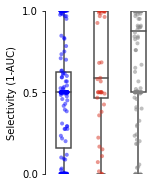

In [10]:
fig, ax = plt.subplots(figsize = [2,3])
sns.despine(bottom=True)
sns.set(font_scale=2.1) 
sns.set_style("ticks")
# plt.title(behaviour_pair, pad=40)

# Create the violin plot
# ax = sns.violinplot(x='State', y='selectivity_auc_inv' ,data=selectivities,
#                     palette = ['#0000ff', '#d7301f', 'gray'], 
#                     cut=0, scale = 'width')
# plt.setp(ax.collections, alpha=.5)

# # Modify the violin plot to be half
# for violin in ax.collections:
#     bbox = violin.get_paths()[0].get_extents()
#     x0, y0, width, height = bbox.bounds
#     violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))

# Create the box plot
sns.boxplot(x='State', y='selectivity_auc_inv' ,data=selectivities, 
            palette = ['#0000ff', '#d7301f', 'gray'], width = 0.4,
            boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)


# Create the half stripplot
sns.stripplot(x='State', y='selectivity_auc_inv' ,data=selectivities,alpha = 0.5, size = 4,
                palette = ['#0000ff', '#d7301f', 'gray'],  dodge=True, ax=ax)

  


# Set the x-axis label, y-axis label, and tick labels
ax.set_xlabel('')
ax.set_ylabel('Selectivity (1-AUC)', labelpad=5)
ax.set_xticklabels( ('', '', ''), rotation=45)

# Set regular tick intervals and y-axis limits
plt.tick_params(bottom=False)
plt.ylim(0,1)
ax.yaxis.set_major_locator(plt.MaxNLocator(2))

# Save the figure
plt.savefig(export_path + str(behaviour_pair) + '_selectivity.pdf', dpi=300, transparent=False, bbox_inches = "tight")

plt.savefig(export_path + str(behaviour_pair) + '_selectivity.png', dpi=300, transparent=False, bbox_inches = "tight")

## linear SVM based tuning

In [ ]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

In [ ]:
IDs = ['JKAA40.3e', 'JKAA40.4i','JKAA40.4h', 'JKAA40.5d', 'JKAA44.2i']
behaviour_pair = ['pup sniff', 'female intruder contact']
num_episodes = {'pup sniff':1,
                'female intruder contact':1}

states = [ 'virgin','PD18']

fr = 20
window = 3
convolve = 'deconvolved'

# build a activities dataset based on virgin & PD18 datasets
activities =  np.empty([0, fr * window])
y = np.empty([0])

for state in states:
    

    for ID in IDs:


        try:
            episodes = extract_episodes(path, 
                                        state,
                                        ID, 
                                        convolve,
                                        window = window, 
                                        num_episodes = num_episodes,
                                        skip_overlap = False)

            


        except FileNotFoundError:
            warnings.warn(f'Recording {ID}_{state} was not found')



        for behav in behaviour_pair:
            try:
            
                num_cells = episodes[behav].shape[1]
                
            
            except KeyError:
                break
            
            
            if behav == behaviour_pair[0]:
                
                y = np.concatenate([y,np.ones(num_cells)], axis = 0)
                
            else:
                
                y = np.concatenate([y,np.zeros(num_cells)], axis = 0)

                
            if episodes == []:
                break

            else:
                try:

                    #num_cells = episodes[behav].shape[0]
                    scores = {}
                    
                    
                    activities = np.concatenate([activities, episodes[behav][0]], axis = 0) 
                    
                    
                except TypeError:
                    pass
            

In [ ]:
episodes['pup sniff'].shape

In [ ]:
fig, ax = plt.subplots(figsize=[10, 25])
fig.tight_layout()


ax.imshow(activities, aspect='auto', cmap='magma')
ax.set_frame_on(False)
ax.set_xticks(np.arange(0, activities.shape[1],  60* fr))
ax.set_xticklabels(np.arange(0, activities.shape[1], 60*fr) // (60 * fr))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Cell #')

In [ ]:
y.shape

In [ ]:
for i in range(int(activities.shape[1]/5)):
    activity = activities[:,i:i+5].reshape(-1, 5)

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(activity, y, 
                                                        test_size=0.1,random_state=20) 
    clf = svm.SVC(kernel='linear', C = 0.5)
    cv = LeaveOneOut()

    clf.fit(X_train, y_train)
    scores = cross_val_score(clf,X_train, y_train, cv=5)
    print(scores.mean())
    y_pred = clf.predict(X_test)

    accuracies = metrics.accuracy_score(y_test, y_pred)
    #print(accuracies)

In [ ]:
fig, ax = plt.subplots(figsize = [10,20])
pd.Series(clf.coef_[0]).nlargest(50).plot(kind='barh')
print(clf.coef_[0].size)

In [ ]:
history = 1
neuron = 5
with_self = False
with_time = True

X = np.array([])

for n, behav in enumerate(bdf.columns):

    regressor = ga.make_design_matrix(bdf[behav], history = history)
    
    if n == 0:
        X = regressor
        
    else:
        X = np.hstack((X, regressor))

extra_regressors = 0
if with_time:
    
    X = np.hstack((X, np.arange(bdf.shape[0]).reshape(-1,1)))
    
    extra_regressors += 1

if with_self:
# Add neuron self history as regressor

    regressor = ga.make_design_matrix(df[neuron], history = history)

    X = np.hstack((X, regressor))
    extra_regressors += 1

    

model = Ridge(alpha = 0, 
              max_iter = 2500,
              normalize = True)

model.fit(X, df[neuron])

labels = list(bdf.columns) + ['Time'] + ['Self']
for n, behav in enumerate(np.split(model.coef_, len(bdf.columns) + extra_regressors)):
    plt.plot(behav, label = labels[n])
    
plt.legend()

print('Explained variance %: ' + str(metrics.explained_variance_score(df[neuron], model.predict(X), multioutput='raw_values')[0] * 100))

In [ ]:
plt.figure(figsize=[10,4])

plt.plot(df[neuron], label= 'Raw activity')
plt.plot(model.predict(X), label = 'Model prediction')
plt.plot(df[neuron] - model.predict(X), label = 'Model error')

plt.legend()

plt.ylabel('dF/F')
plt.xlabel('Time (min)')

### Tuning to shuffled calcium data

In [ ]:
path = '/Volumes/lab-kohlj/home/users/borakn/Data/'

df = load_inscopix(path + '/Inscopix/C00547699_dom_baseline_RI_male.csv')

_, bdf, _ = preprocess_behaviour(path + '/Behaviour/Inscopix/C00547699_dom_baseline_RI_male.csv', df.shape[1])

In [ ]:
for n, cell in enumerate(df):
    np.random.shuffle(df[n])

shuffled_aucs = {}
for behav in bdf.columns[1:]:
    
    shuffled_aucs[behav] = estimate_tuning(df, bdf, behav, remove_nontarget = False, subtract_shuffled_tuning=False)
    
shuffled_aucs = pd.DataFrame(shuffled_aucs)

In [ ]:
%matplotlib widget

plt.figure()
plt.hist(shuffled_aucs, color=['C1', 'C2', 'C3'])
plt.ylabel('Frequency')
plt.xlabel('Tuning to shuffled calcium data')
plt.legend(shuffled_aucs.columns)

# plt.savefig('/Users/borakn/Documents/PhD/Plots/GRIN/shuffled_tuning_histogram.png', dpi=600)

## visualisation for selectivities based on choice probability

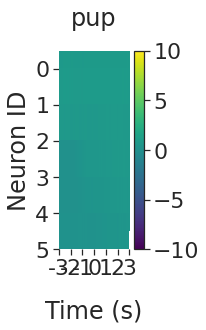

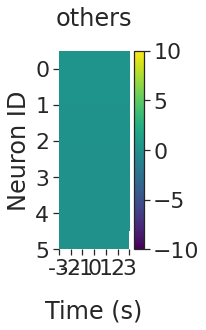

In [12]:
fb = np.array(list(selectivities[selectivities.selectivity_auc_inv == 1].first_baseline))
fa = np.array(list(selectivities[selectivities.selectivity_auc_inv == 1].first_activities))
first = np.concatenate([fb,fa],axis = 1)[:5]

sb = np.array(list(selectivities[selectivities.selectivity_auc_inv == 1].second_baseline))
sa = np.array(list(selectivities[selectivities.selectivity_auc_inv == 1].second_activities))
second = np.concatenate([sb,sa],axis = 1)[:5]

fig = ga.plot_amplitude(first, 'pup', 'viridis',clustering = False)
fig = ga.plot_amplitude(second, 'others', 'viridis',clustering = False)


In [13]:
fb = np.array(list(selectivities[selectivities.selectivity_auc_inv == 0].first_baseline))
fa = np.array(list(selectivities[selectivities.selectivity_auc_inv == 0].first_activities))
first = np.concatenate([fb,fa],axis = 1)[:5]

sb = np.array(list(selectivities[selectivities.selectivity_auc_inv == 0].second_baseline))
sa = np.array(list(selectivities[selectivities.selectivity_auc_inv == 0].second_activities))
second = np.concatenate([sb,sa],axis = 1)[:5]


fig = ga.plot_amplitude(first, 'pup', clustering = False)
fig = ga.plot_amplitude(second, 'others', clustering = False)


TypeError: plot_amplitude() missing 1 required positional argument: 'cmap'